In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashvrdnjain/hotdognothotdog")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hotdognothotdog


In [2]:
import pandas as pd
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50



In [3]:
directory = f'{path}/hotdog-nothotdog/train/'
test_directory = f'{path}/hotdog-nothotdog/test/'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # 20% validation split
    rotation_range=20,         # randomly rotate images by 0–20 degrees
    width_shift_range=0.1,     # randomly shift images horizontally (10% of width)
    height_shift_range=0.1,    # vertically (10% of height)
    shear_range=0.2,           # shear angle in counter-clockwise direction
    zoom_range=0.2,            # zoom in/out
    horizontal_flip=True,      # randomly flip images horizontally
    fill_mode='nearest'        # how to fill in newly created pixels
)

# Validation data generator — no augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_dataset = train_datagen.flow_from_directory(
    directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    seed=123
)

# Validation generator
val_dataset = val_datagen.flow_from_directory(
    directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    seed=123
)

test_dataset = image_dataset_from_directory(
    test_directory,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=123
)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 644 files belonging to 2 classes.


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='hotdog_convnet.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [16]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 712ms/step - accuracy: 0.5099 - loss: 0.8129 - val_accuracy: 0.4817 - val_loss: 0.7113
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 447ms/step - accuracy: 0.5490 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 0.7563
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - accuracy: 0.5329 - loss: 0.6900 - val_accuracy: 0.4817 - val_loss: 0.7102
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 434ms/step - accuracy: 0.5379 - loss: 0.6896 - val_accuracy: 0.4917 - val_loss: 0.7152
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 443ms/step - accuracy: 0.5440 - loss: 0.6862 - val_accuracy: 0.4300 - val_loss: 0.7187
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 442ms/step - accuracy: 0.5607 - loss: 0.6842 - val_accuracy: 0.5067 - val_loss: 0.7139
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 446ms/step - accuracy: 0.5760 - loss: 0.6745 - val_accuracy: 0.5217 - val_loss: 0.7133
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 435ms/step - accuracy: 0.5617 - loss: 0.6802 - val_accu

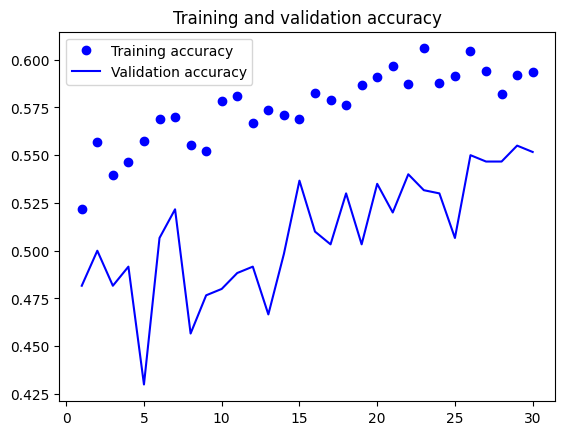

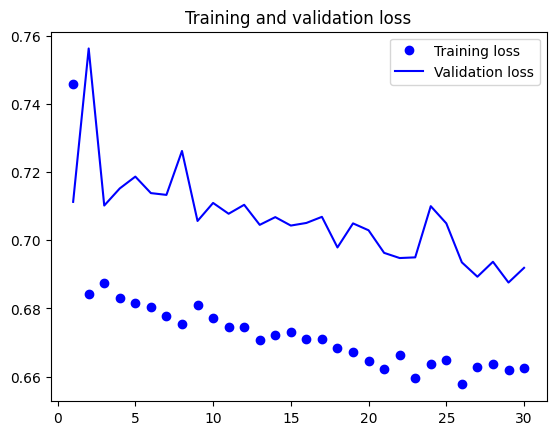

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(dataset, model_arg):
    Y_true = []
    Y_pred = []
    # Loop through the batches in the original 3-channel dataset
    for images, labels in dataset:
        predictions = model_arg.predict(images)
        Y_true.extend(labels)
        Y_pred.extend(np.round(predictions).flatten())  # round for binary labels
    # Convert to arrays for metrics
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)
    # Compute metrics
    accuracy = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")


evaluate(test_dataset, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Accuracy:  0.4767
Precision: 0.4839
Recall:    0.6988
F1 Score:  0.5718
